## Toxic: Preprocessing and K-Means Clustering / T-SNE

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from wordcloud import WordCloud, STOPWORDS
from sklearn.manifold import TSNE

from time import time
import math

In [57]:
df = pd.read_pickle('../data/toxictrain.pkl')
print(df.shape)
# df.head()

(159571, 30)


### Assumptions

In [173]:
df_t = df[df['rating']>0]
df_nt = df[df['rating']==0]
print(df_t.shape)

seed = 42

categories = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

(16225, 30)


In [168]:
# Code inspired by https://github.com/ailchau/Metis_Projects/blob/master/wrangling_with_restaurant_reviews/wrangling_with_restaurant_reviews.ipynb
def reduce_dimension(data,n_clusters):
    # Dimensionality Reduction
    tfidf = TfidfVectorizer(max_df=0.6)
    X = tfidf.fit_transform(data)
    nmf = NMF(n_components=n_clusters, random_state=seed, alpha=.1, l1_ratio=.5, init='nndsvd')
    X_reduced = nmf.fit_transform(X)
    
    return X_reduced

def plot_kmc(X_reduced, n_clusters,tag):
    # plot K Means Clusters Silhouette and Clusters Analysis
    ns = np.arange(2, 20, 1)
    inertias = []
    silhouettes = []
    for n in ns:
        kmeans = KMeans(n_clusters=n, init="k-means++", random_state=seed).fit(X_reduced)
        inertias.append(kmeans.inertia_)
        labels = kmeans.labels_
        ss = silhouette_score(X_reduced, labels, metric='euclidean',sample_size=5000, random_state=seed)
        silhouettes.append(ss)
        
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,2,1)
    # plot the inertia scores and look for the kink in the curve
    plt.plot(ns, inertias)
    plt.xlabel('Clusters')
    plt.ylabel('SSE')
    plt.title('K-Means Inertia: ' + tag, fontweight='bold',fontsize=16)

    ax = fig.add_subplot(1,2,2)
    # plot the silhouette scores
    plt.plot(ns, silhouettes)
    plt.xlabel('Clusters')
    plt.ylabel('Silhouette Coefficient')
    plt.title('K-Means Silhouette Scores: ' + tag, fontweight='bold',fontsize=16)

    plt.tight_layout()
    filepath1 = "../charts/kmc_" + tag + ".png"
    plt.savefig(filepath1)
    print("KMC saved at " + filepath1)
    # Fit Kmeans with n_clusters
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=seed)
    kmf = kmeans.fit(X_reduced)
    labels = kmf.labels_
    ssc = silhouette_score(X_reduced, labels, metric='euclidean',sample_size=5000, random_state=seed)

    print("Inertia score: {}".format(kmf.inertia_))
    print("Silhouette score: {}".format(ssc))
    for cluster in range(len(set(labels))):
        print("Cluster {} has {} comments.".format(cluster, sum(labels==cluster))) 
        
    return X_reduced, labels

def create_wordcloud(text,width,height,max_words,title):
    wordcloud = WordCloud(stopwords=STOPWORDS, width=width,height=height,max_words=max_words).generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title,fontweight='bold',fontsize=16)

def wordcloud_visualizations(data,X_reduced,comments,labels,n_clusters,ncols,tag):
    cluster_map = pd.DataFrame(X_reduced)
    cluster_map['comments'] = [r for r in data]
    cluster_map['cluster'] = labels
    
    fig = plt.figure(figsize=(30,20))
    ncols = ncols
    nrows = math.ceil(n_clusters / ncols)
    plt.tight_layout()

    for i in range(n_clusters):
        ax = fig.add_subplot(nrows,ncols,i+1)
        cluster = ''.join(cluster_map[cluster_map.cluster==i].comments)
        create_wordcloud(cluster,400,200,50,'Cluster {}'.format(i))
    filepath3 = "../charts/wc_kmctsne_" + tag + ".png"
    print("WordClouds saved at " + filepath3)
    plt.savefig(filepath3)
        
def plot_tsne(X_reduced, labels,tag):
    tsne = TSNE(n_components=2, perplexity=40, n_iter=500, random_state=seed)
    tsne = tsne.fit_transform(X_reduced)
    df_tsne = pd.DataFrame(tsne, columns=["tsne_x", "tsne_y"])
    df_tsne["Cluster"] = labels
    
    fig = plt.figure(figsize=(60,60))
    tsne = sns.lmplot("tsne_x", "tsne_y", data=df_tsne, fit_reg=False, hue="Cluster")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("T-SNE: " + tag + " Clusters",fontweight='bold')
    filepath2 = "../charts/tsne_" + tag + ".png"
    plt.savefig(filepath2)
    print("T-SNE saved at " + filepath2)
    
def create_kmc_tsne(data, n_clusters, seed, ncols,tag):
    # wrapper function
    X_reduced, labels = plot_kmc(reduce_dimension(data,n_clusters),n_clusters,tag)
    wordcloud_visualizations(X_reduced,data,labels,n_clusters,ncols,tag)
    plot_tsne(X_reduced,labels,tag)

In [169]:
data = df_t.comment_text
n_clusters = 8
tag = 'Toxic'
ncols = 3

X_reduced = reduce_dimension(data, n_clusters)

KMC saved at ../charts/kmc_Toxic.png
Inertia score: 5.152774344036721
Silhouette score: 0.25030490324250065
Cluster 0 has 835 comments.
Cluster 1 has 3262 comments.
Cluster 2 has 912 comments.
Cluster 3 has 5897 comments.
Cluster 4 has 1932 comments.
Cluster 5 has 370 comments.
Cluster 6 has 1602 comments.
Cluster 7 has 1415 comments.


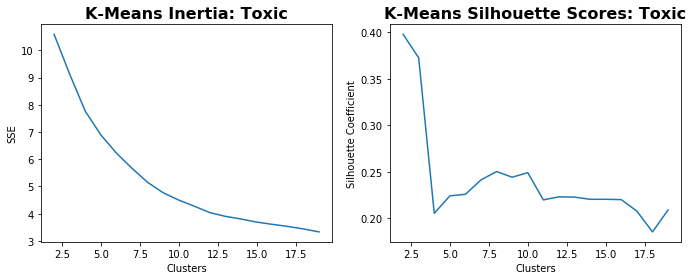

In [170]:
X_reduced, labels = plot_kmc(X_reduced,n_clusters,tag)

WordClouds saved at ../charts/wc_kmctsne_Toxic.png


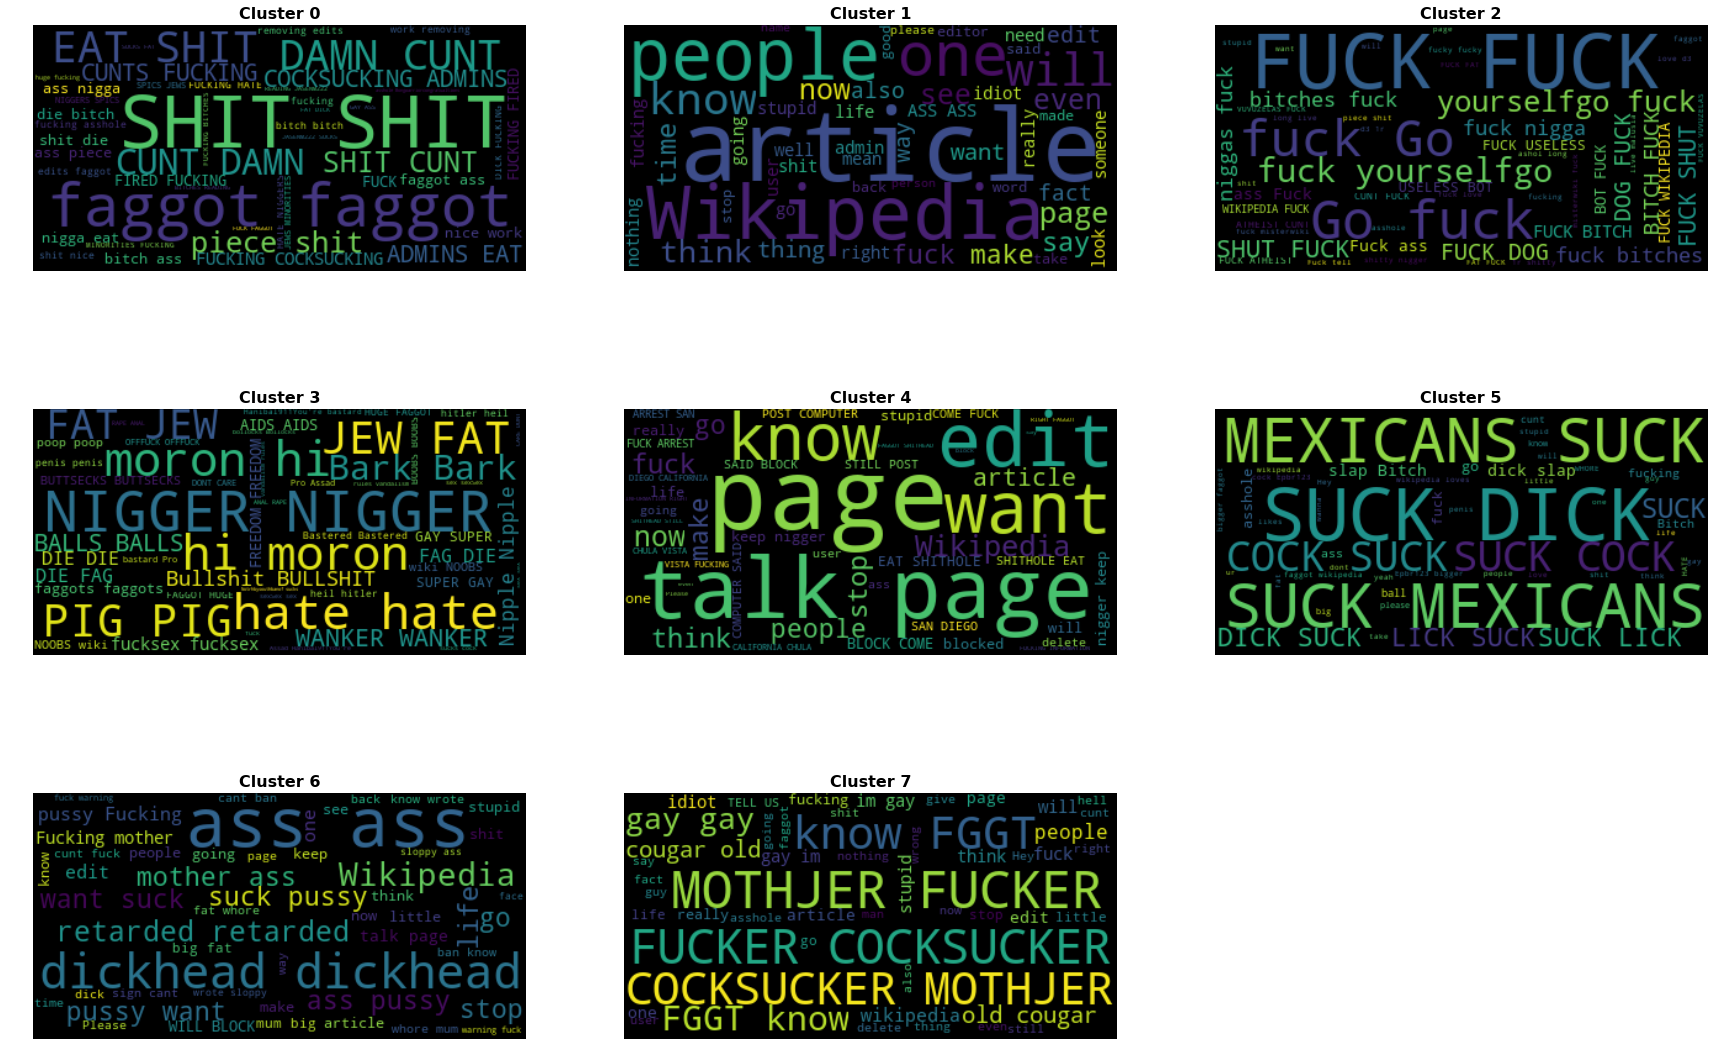

In [158]:
wordcloud_visualizations(data,X_reduced,data,labels,n_clusters,ncols,tag)

T-SNE saved at ../charts/tsne_Toxic.png


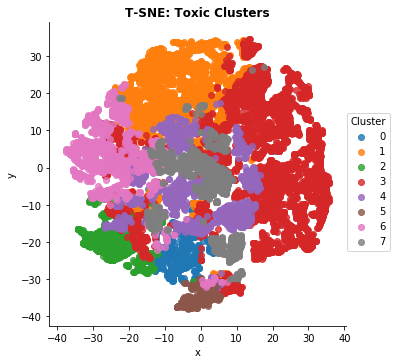

In [159]:
_ = plot_tsne(X_reduced, labels, tag)

KMC saved at ../charts/kmc_All_Words.png
Inertia score: 9.383863976765072
Silhouette score: 0.23288724296767774
Cluster 0 has 27797 comments.
Cluster 1 has 1406 comments.
Cluster 2 has 78266 comments.
Cluster 3 has 1788 comments.
Cluster 4 has 47071 comments.
Cluster 5 has 905 comments.
Cluster 6 has 1238 comments.
Cluster 7 has 1100 comments.
WordClouds saved at ../charts/wc_kmctsne_All_Words.png
T-SNE saved at ../charts/tsne_All_Words.png


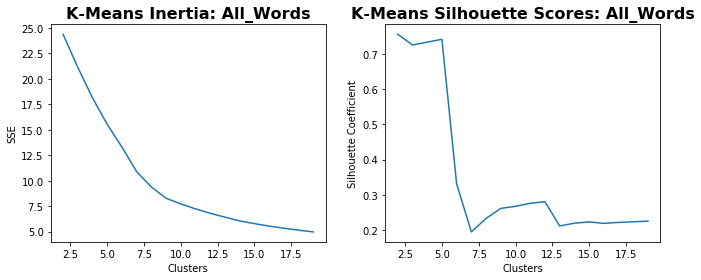

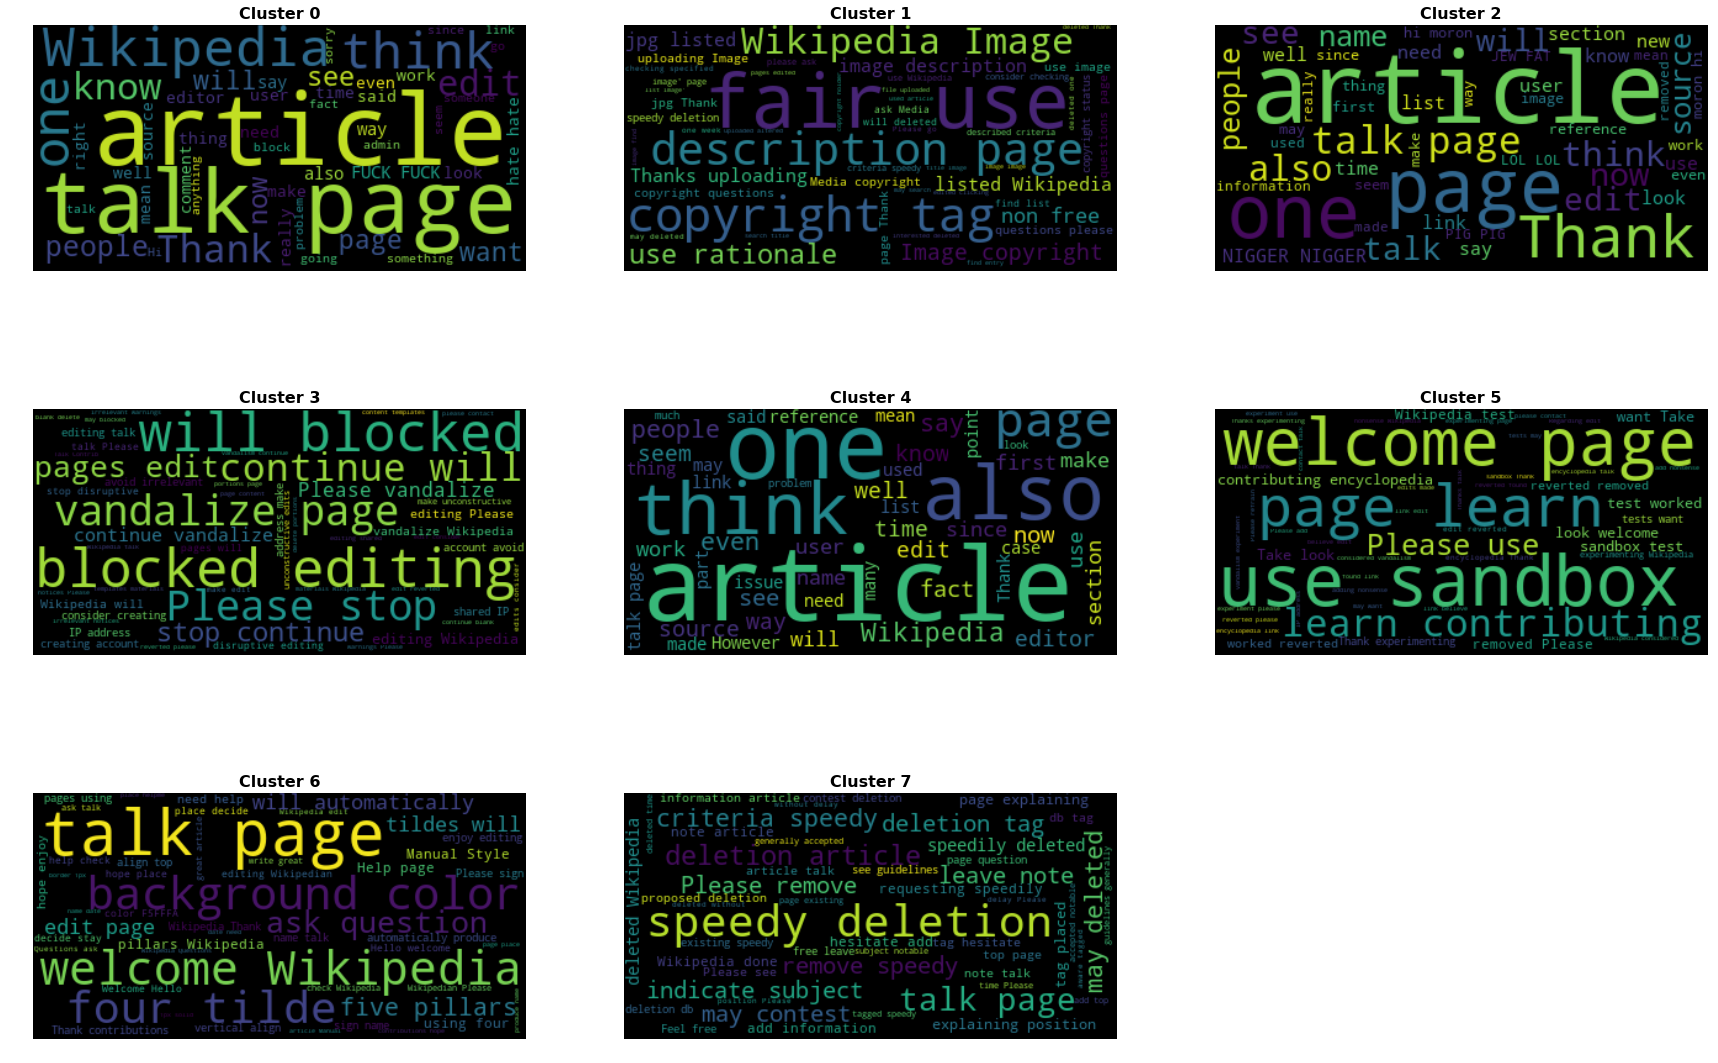

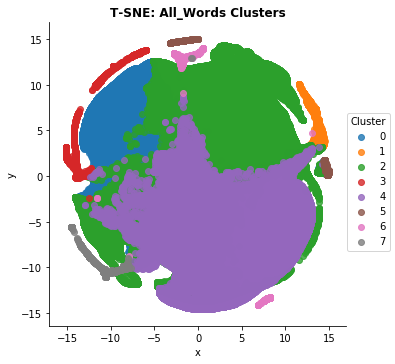

In [176]:
data = df.comment_text
n_clusters = 8
tag = 'All_Words'
ncols = 3

X_reduced = reduce_dimension(data, n_clusters)
X_reduced, labels = plot_kmc(X_reduced,n_clusters,tag)
wordcloud_visualizations(data,X_reduced,data,labels,n_clusters,ncols,tag)
_ = plot_tsne(X_reduced, labels, tag)